In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# RFM - Customer Segmentation Using K-Means Clustering

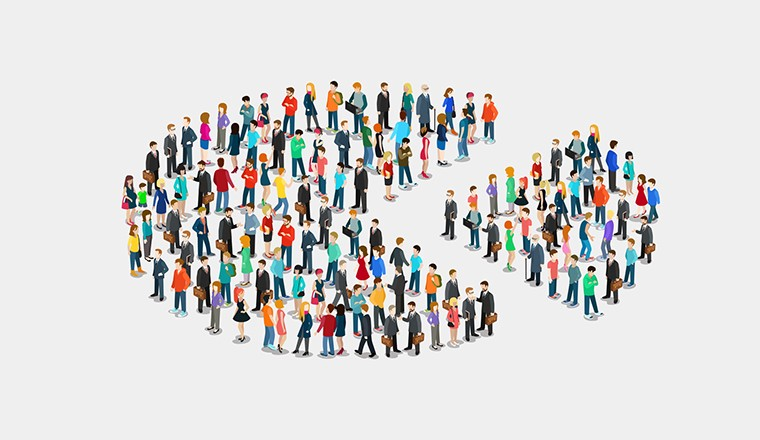

# Table of Content

1. [Import Library and Set Configurations](#section-one)  
2. [Load Dataset](#section-two)  
3. [Exploratory Data Analysis](#section-three) 
    * 3.1. [Country](#section-three-one)  
    * 3.2. [StockCode & Description](#section-three-two)  
    * 3.3. [Price & Quantity](#section-three-three)  
    * 3.4. [Total Price](#section-three-four)  
4. [RFM Metrics](#section-four)  
5. [K-Means](#section-five)  
    * 5.1. [Determining the Optimum Number of Clusters](#section-five-one)


    
    
    

<a id="section-one"></a>
## 1. Import Library and Set Configurations

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
pip install openpyxl

<a id="section-two"></a>
## 2. Load Dataset

In [ ]:
df_ = pd.read_excel("../input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx", 
                    sheet_name="Year 2009-2010", engine='openpyxl') 
df = df_.copy()
df.head()

<a id="section-three"></a>
## 3. Exploratory Data Analysis 

In [ ]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(5))
    print("##################### Tail #####################")
    print(dataframe.tail(5))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

at first glance:
* Customer ID is duplicated
* null values in Description and Customer ID variables
* Customer ID's will be used for identifying customers on customer segmentation, so null values is both variables will be dropped.
* Price and Quantity variables have values below zero, which is not possible.
* Prices range from 0 to 25111

In [ ]:
# drop null values

df.dropna(inplace=True)

In [ ]:
# check one randomly picked customer's shopping history

df.loc[df['Customer ID'] == 13085.00000]

When a customer makes a purchase, the Invoice is duplicated and each unique item that has been purchased are transformed into seperate observations.

In [ ]:
# number of unique customers

df['Customer ID'].nunique()

<a id="section-three-one"></a>
### 3.1. Country

In [ ]:
# which countries are the customers from

df['Country'].value_counts()

In [ ]:
# customers without country information

df.loc[df['Country'] == "Unspecified", "Customer ID"].value_counts()


In [ ]:
missing_country = [16320.00000,14265.00000,12470.00000,12351.00000,15357.00000]

df.loc[df['Customer ID'].isin(missing_country)].head(5)


5 customers' Country variables are empty, we won't be using Country information for segmentation so we'll leave them as is.

<a id="section-three-two"></a>
### 3.2. StockCode & Description

In [ ]:
#do each StockCode belong to a specific Item

df.groupby('StockCode').agg({'Description': "nunique"}).sort_values(by='Description', ascending=False).head()

In [ ]:
df.loc[df['StockCode'] == 22384, 'Description'].unique()

As an example, 4 item names above refer to the same item and StockCode. This duplicate may be due to manuel entry. StockCode is a better variable to analyze items.

<a id="section-three-three"></a>
### 3.3. Price & Quantity

In [ ]:
# check the observations that have negative value for Quantity 

df.loc[df['Quantity'] < 0].head(10)

In [ ]:
# check the Invoices that starts with the letter "C"

df.loc[df['Invoice'].str.startswith("C",na=False), ["Quantity","Price"]].describe()

Invoices that start with "C" are refunds, the Quantity values are below 0.

In [ ]:
# get rid of refund invoices

df = df[~df["Invoice"].str.contains("C", na=False)]

In [ ]:
df.describe().T

<a id="section-three-four"></a>
### 3.4. Total Price

In [ ]:
# derive a new variable by multiplying the price per unit with Quantity

df['TotalPrice'] = df['Quantity'] * df['Price']

In [ ]:
df.head()

<a id="section-four"></a>
## 4. RFM Metrics 

* **Recency** shows how recent the customer has purchased. So that is the duration between today and the last date that the customer has purchased. Today will be the last date within the dataset.  
* **Frequency** shows how frequent the customer purchases. So the number of unique Invoices will be the number of times that he/she purchased.
* **Monetary** shows the total amount of money that the customer has spent.


In [ ]:
today_date = df['InvoiceDate'].max() + dt.timedelta(days=2)

In [ ]:
# 2 days will be added to "today's date" to eliminate the local time differences between stores and to make sure
# that Recency is always above 0

today_date = df['InvoiceDate'].max() + dt.timedelta(days=2)
today_date

In [ ]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                    'Invoice': lambda inv: inv.nunique(),
                                    'TotalPrice': lambda price: price.sum()})

In [ ]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [ ]:
rfm.head()

In [ ]:
check_df(rfm)

no negative values, no null values

<a id="section-five"></a>
##  5.K-Means

* Instead of using a pre-defined number of clusters, the customers will be segmented according to their purchasing behaviours.  
* The logic behind K-Means is to cluster every observation with regards to their similarities using Sum of Squared Distances (SSD).

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

sc = MinMaxScaler((0, 1))
df = sc.fit_transform(rfm)

Monetary values range from 0 to 349164 whereas Recency and Frequency values range form 1 to a 3 digit number. By using MinMaxScaler, all the values are ranging from 0 to 1 (its default parameter). 

In [ ]:
df[0:5]

In [ ]:
# a random number of cluster is being given as a parameter

kmeans = KMeans(n_clusters=4)
k_fit = kmeans.fit(df)

In [ ]:
# centeroids for the 4 clusters

k_fit.cluster_centers_

<a id="section-five-one"></a>
### 5.1. Determining the Optimum Number of Clusters

Elbow Method will be used to determine the optimum number of clusters for rfm dataframe

In [ ]:
import matplotlib.pyplot as plt
# number of clusters between range(1,30) will be given as parameters within KMeans object

kmeans = KMeans()
ssd = []
K = range(1, 30)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df)
    ssd.append(kmeans.inertia_)
    
plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums per Different k Values")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k=(2, 20))
visu.fit(df)
visu.show();

According to Elbow Method, the optimum number of cluster is 6.

In [ ]:
kmeans = KMeans(n_clusters= 6, init= 'k-means++', max_iter= 1000)
kmeans.fit(df)
clusters = kmeans.labels_

* ‘k-means++’ parameter selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.  
* 'max_iter' parameter for the maximum number of iterations of the k-means algorithm for a single run. It is given in order to avoid an endless loop.

In [ ]:
# segment labels for the first 30 customers

clusters[0:30]

In [ ]:
# customer id's and the segment numbers

pd.DataFrame({"Customer ID": rfm.index, "Clusters": clusters})

In [ ]:
# add cluster numbers as a variable to rfm dataframe
# add 1 to cluster segment number so that it starts with 1

rfm["Cluster"] = clusters
rfm["Cluster"] = rfm["Cluster"] + 1

In [ ]:
rfm.head(15)